# Gaussian Fitting for Multiple Lines
We have successfully fit a Gaussian to our lines that only have one peak. However, there are some instances where lines overlap. In order to calculate the brightness for these lines, we must use multiple Gaussian peak fitting.


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [24]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

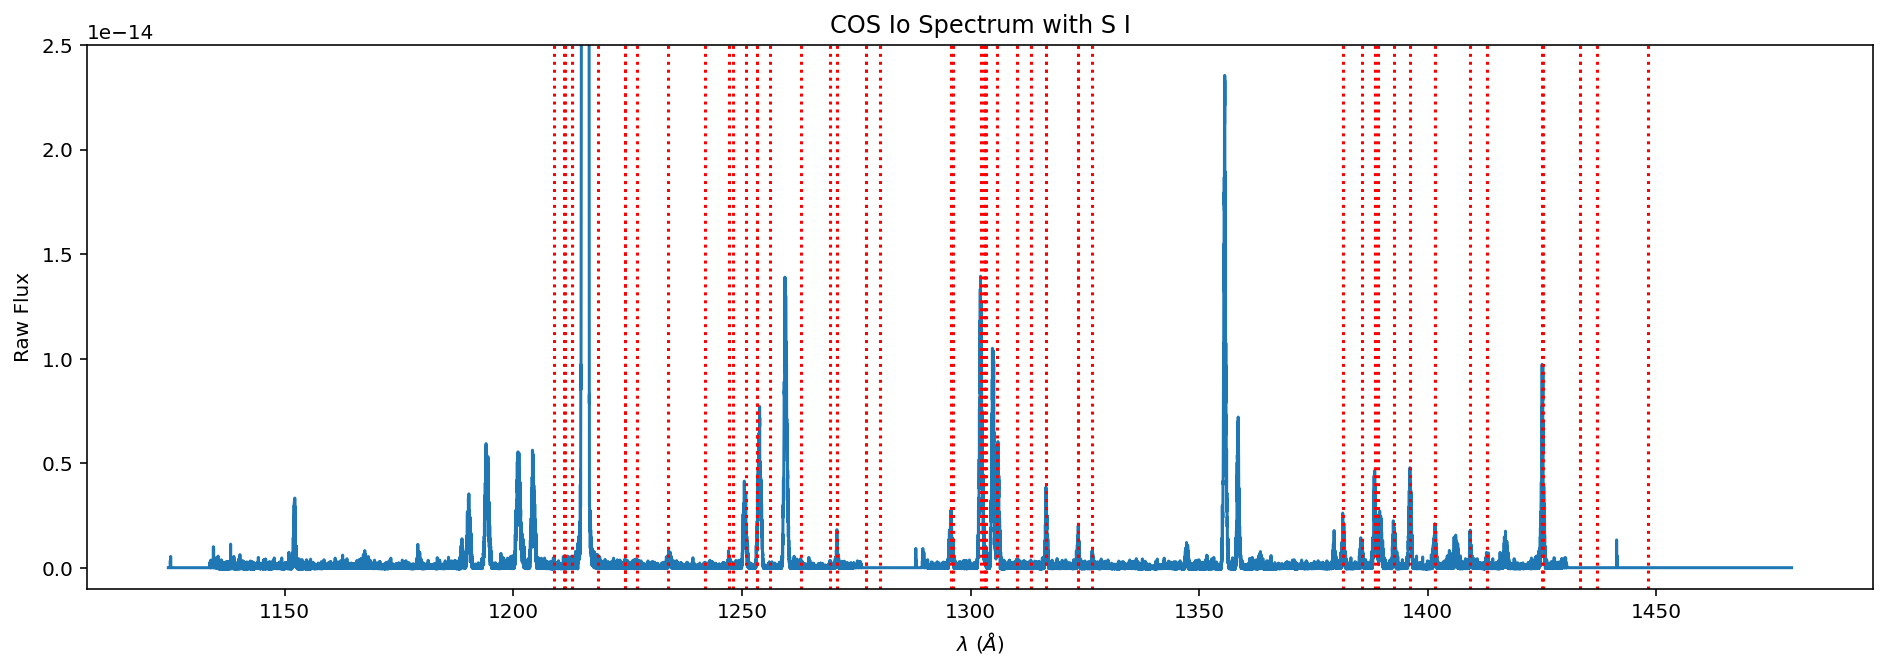

In [25]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.ylim(-0.01*10**-13,0.25*10**-13)
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

Instead of having one line, we now have two. I have handpicked a portion of the spectrum where the two Gaussians overlap.

(-5e-16, 1.5e-14)

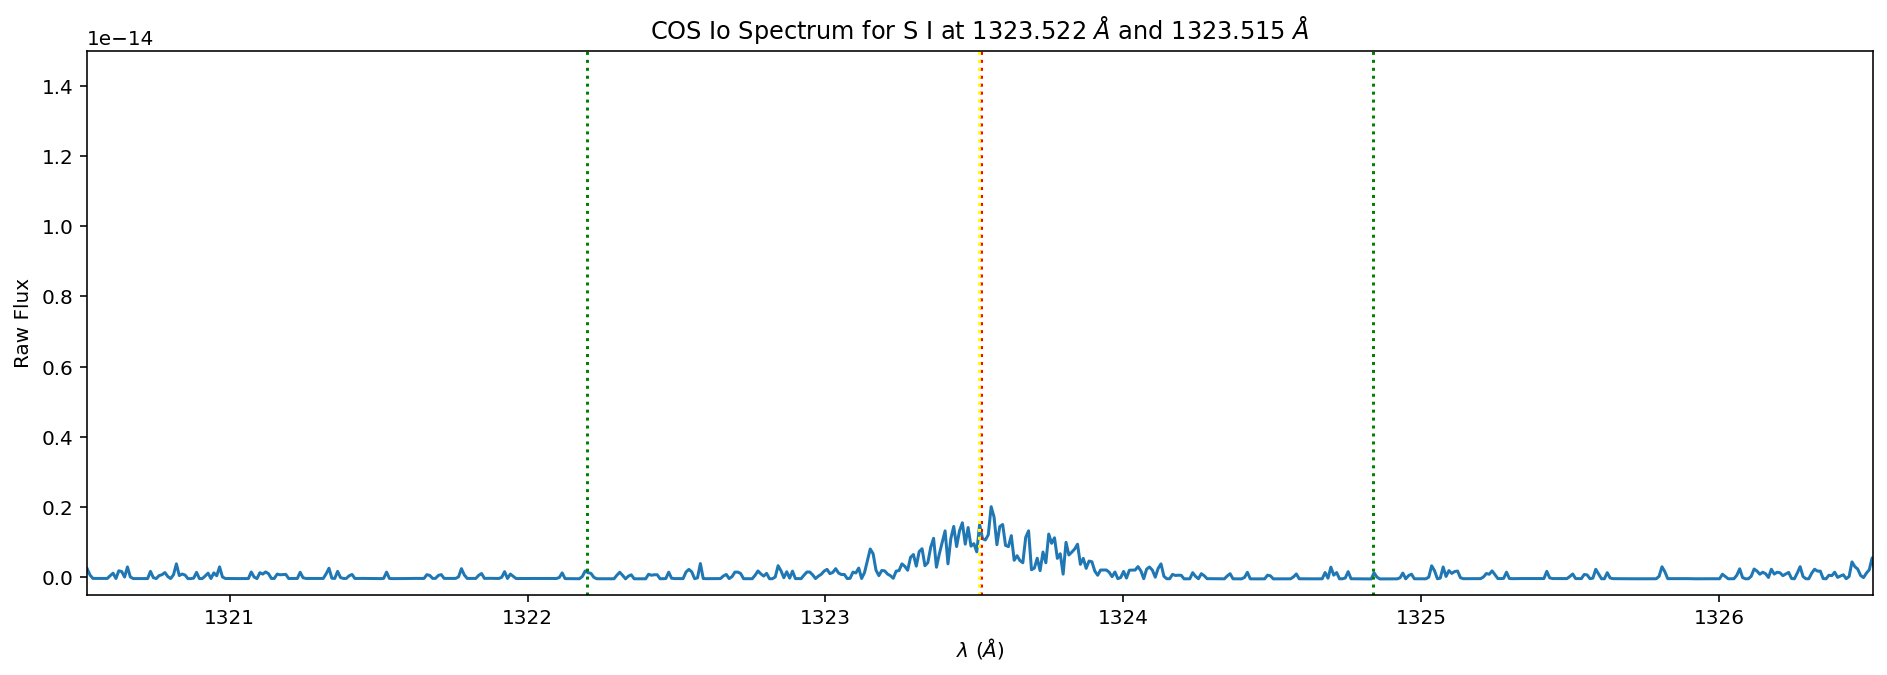

In [27]:
line_1 = 1323.5150
line_2 = 1323.5220
left_bound = 0.999*line_2
right_bound = 1.001*line_1
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$ and {} $\AA$".format(line_2,line_1))
plt.axvline(line_2, color = 'red', linestyle = 'dotted')
plt.axvline(line_1, color = 'yellow', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line_2-3,line_1+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

In [28]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]
unc = 0.1*flux #placeholder uncertainty
wl_array = wl.data
flux_array = flux.data

(1320.522, 1326.515)

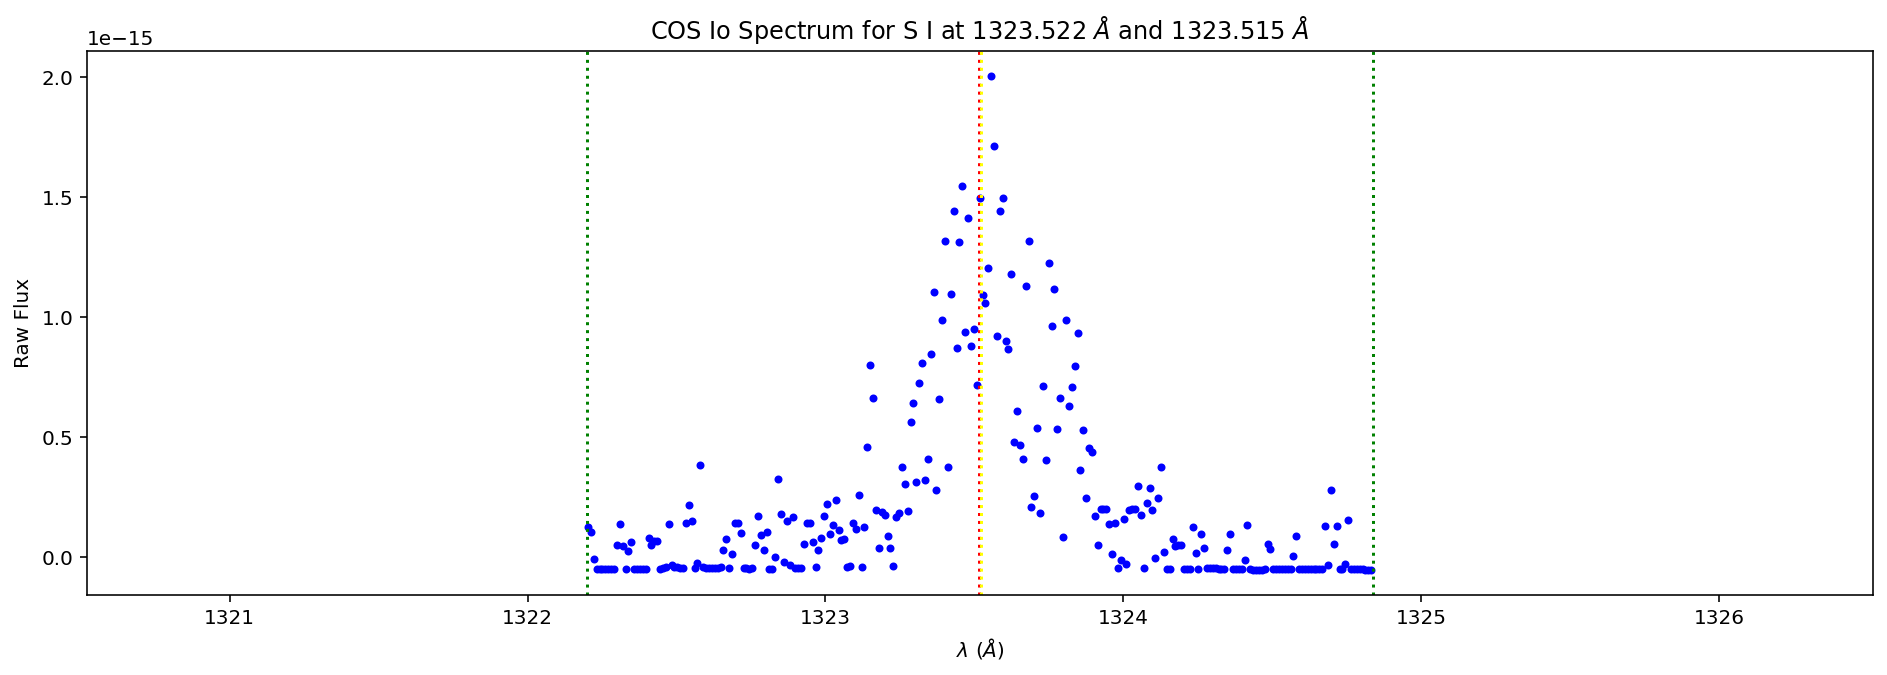

In [30]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$ and {} $\AA$".format(line_2,line_1))
plt.axvline(line_1, color = 'red', linestyle = 'dotted')
plt.axvline(line_2, color = 'yellow', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line_2-3,line_1+3)
#plt.ylim(-0.005*10**-13,0.15*10**-13)

Now let's define the Gaussian functions for the first line and the second line.

In [31]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

In [32]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen2)/sigma2)**2)))

With these functions, we can define guesses for the amplitude, width, and center wavelength.

In [33]:
amp1 = 1*10**-15
sigma1 = 1
cen1 = line_1

amp2 = 1*10**-15
sigma2 = 1
cen2 = line_2

In [34]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [35]:
pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = _1gaussian(wl_array, *pars_1)
gauss_peak_2 = _1gaussian(wl_array, *pars_2)

In [36]:
a1 = popt_2gauss[0]
a1_err = perr_2gauss[0]
mu1 = popt_2gauss[1]
mu1_err = perr_2gauss[1]
w1 = popt_2gauss[2]
w1_err = perr_2gauss[2]

a2 = popt_2gauss[3]
a2_err = perr_2gauss[3]
mu2 = popt_2gauss[4]
mu2_err = perr_2gauss[4]
w2 = popt_2gauss[5]
w2_err = perr_2gauss[5]

In [37]:
print("amplitude_1 = {} (+/-) {}".format("{:e}".format(a1), "{:e}".format(a1_err)))
print("mu_1 = {} (+/-) {}".format(mu1, "{:e}".format(mu1_err)))
print("sigma_1 = {} (+/-) {}".format((w1), "{:e}".format(w1_err)))

print("\namplitude_2 = {} (+/-) {}".format("{:e}".format(a2), "{:e}".format(a2_err)))
print("mu_2 = {} (+/-) {}".format(mu2, "{:e}".format(mu2_err)))
print("sigma_2 = {} (+/-) {}".format((w2), "{:e}".format(w2_err)))

amplitude_1 = 5.154082e-12 (+/-) inf
mu_1 = 134033.12634057476 (+/-) inf
sigma_1 = 502.8538557609958 (+/-) inf

amplitude_2 = -5.154218e-12 (+/-) inf
mu_2 = -131350.58454887095 (+/-) inf
sigma_2 = 426.36900796142805 (+/-) inf


Now, let's save the amplitude, center wavelength, and width for each Gaussian.

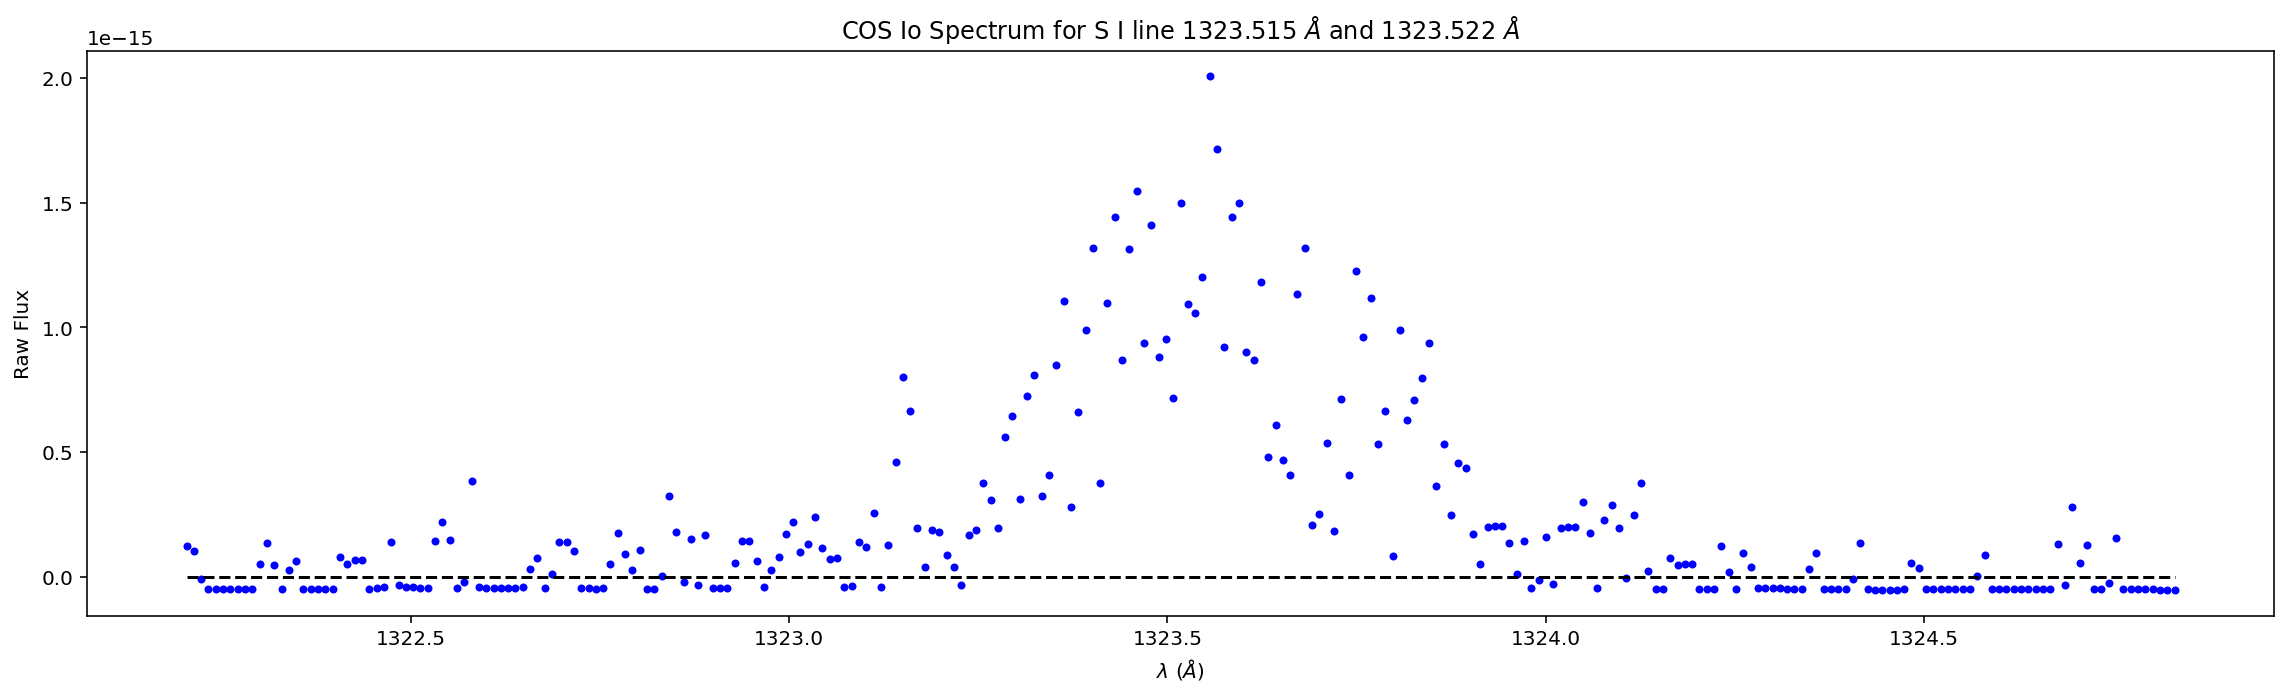

In [38]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.')
plt.plot(wl_array, _2gaussian(wl_array, *popt_2gauss), 'k--')
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I line {} $\AA$ and {} $\AA$".format(line_1,line_2))
plt.tight_layout()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/'
plt.savefig(save_place+"gauss_mult_fit_{}_{}.jpg".format(line_1,line_2), format="jpg",dpi=1000)

Now let us calculate the brightness with the given amplitude and width of the curve. The integral of a Gaussian function is given by $$\int_{-\infty}^\infty a\,e^{-\left( x-b \right)^2/2c^2}\,dx=\sqrt{2\pi} a \, \left\vert c \right\vert \, $$ where in this case, $a$ corresponds to the amplitude and $c$ corresponds to the width.

In [18]:
brightness_1 = ((2*np.pi)**.5)*(a1*w1)
print("The brightness of S I at {} Angstrom is {}.".format(line_1,brightness_1))

The brightness of S I at 1296.174 Angstrom is 1.1120456025695636e-16.


In [19]:
brightness_2 = ((2*np.pi)**.5)*(a2*w2)
print("The brightness of S I at {} Angstrom is {}.".format(line_2,brightness_2))

The brightness of S I at 1295.652 Angstrom is 6.066395143929987e-16.


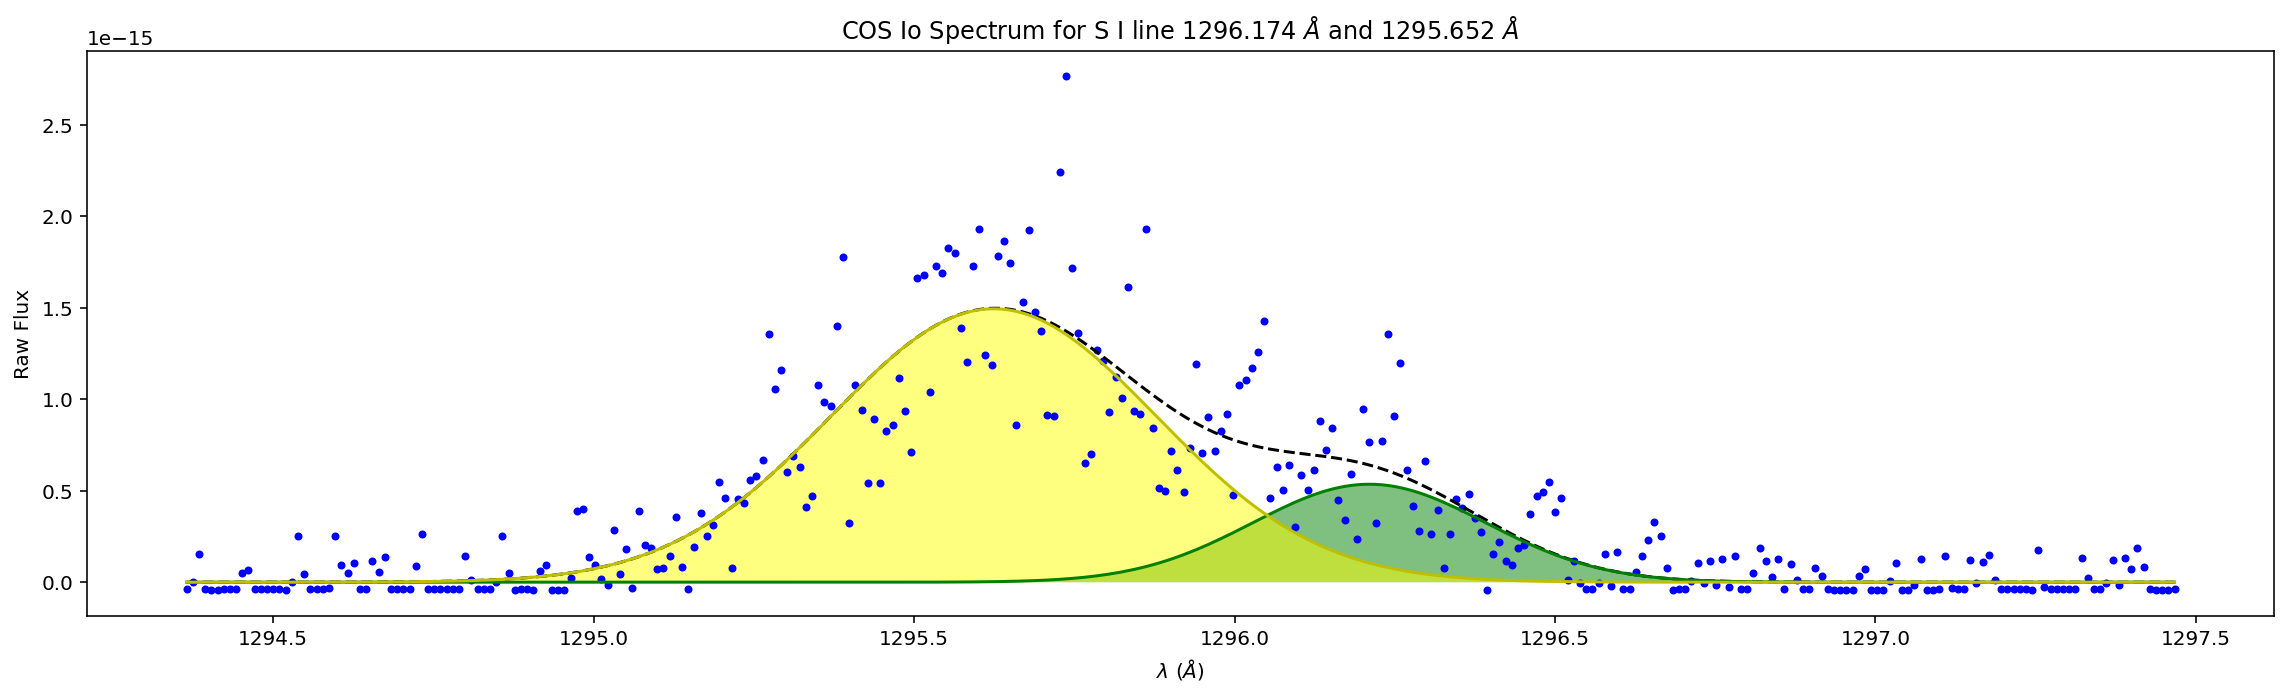

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.')
plt.plot(wl_array, _2gaussian(wl_array, *popt_2gauss), 'k--')
plt.plot(wl_array, gauss_peak_1, "g")
plt.fill_between(wl_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
plt.plot(wl_array, gauss_peak_2, "y")
plt.fill_between(wl_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I line {} $\AA$ and {} $\AA$".format(line_1,line_2))
plt.tight_layout()

In [21]:
residual_2gauss = flux_array - (_2gaussian(wl_array, *popt_2gauss))

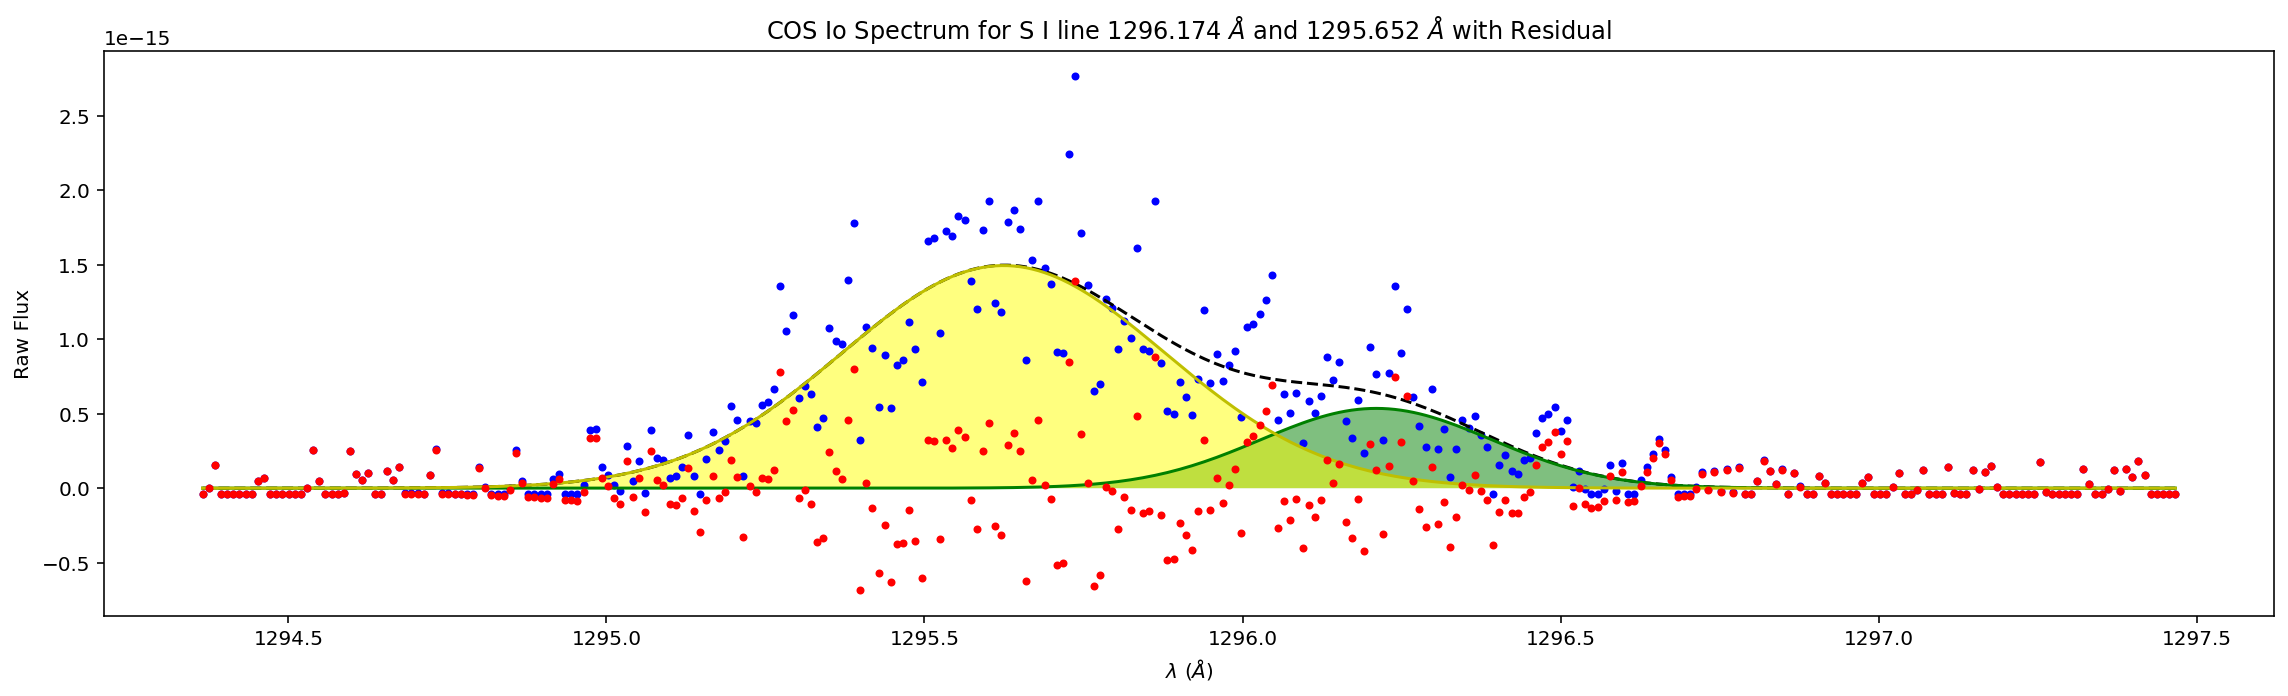

In [22]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.')
plt.plot(wl_array, _2gaussian(wl_array, *popt_2gauss), 'k--')
plt.plot(wl_array, gauss_peak_1, "g")
plt.fill_between(wl_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
plt.plot(wl_array, gauss_peak_2, "y")
plt.fill_between(wl_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)
plt.plot(wl_array, residual_2gauss, "r.")
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I line {} $\AA$ and {} $\AA$ with Residual".format(line_1,line_2))
plt.tight_layout()